In [188]:
import numpy as np
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.patches as patches
import glob

## Load in data

In [6]:
data = pd.read_csv('meta_pcs.csv').dropna(subset=['PC1','PC2'])

In [8]:
# Don't rerun - takes a while!
# kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(data[['PC1', 'PC2']].values)
# log_density = kde.score_samples(data[['PC1','PC2']].values)
# data['PC1_PC2_density'] = np.exp(log_density)

# data.to_csv('meta_pcs_density.csv')

In [54]:
data_dens = pd.read_csv('meta_pcs_density.csv')

## Categorical sampliing

### IDs for each center

In [87]:
# centers = data_dens['assessment_center'].unique()
# centers_keep = [c for c in centers if c not in ['Swansea','Wrexham','Stockport (pilot)']]
# filtered_rows = data_dens[data_dens['assessment_center'].isin(centers_keep)]
plink_header=['X1','X2','Clust']
data_dens[['id','id','assessment_center']].to_csv('../subsampling/ids_assessment_center.tsv',index=False,sep="\t",header=plink_header)

In [88]:
## WB only
filtered_rows_WB = data_dens[data_dens['ethnic_background']=='British']
filtered_rows_WB[['id','id','assessment_center']].to_csv('../subsampling/ids_assessment_center_WB.tsv',index=False,sep="\t",header=plink_header)

### IDs for birth country comparison (mainland UK)

In [89]:
countries_keep = ['England','Scotland','Wales']
filtered_rows = data_dens[data_dens['birth_UKelsewhere'].isin(countries_keep)]
filtered_rows[['id','id','birth_UKelsewhere']].to_csv('../subsampling/ids_country_UKmainland.tsv',index=False,sep="\t",header=plink_header)

In [91]:
## WB only
filtered_rows_WB = filtered_rows[filtered_rows['ethnic_background']=='British']
filtered_rows_WB[['id','id','birth_UKelsewhere']].to_csv('../subsampling/ids_country_UKmainland_WB.tsv',index=False,sep="\t",header=plink_header)

## Distance-based sampling

## PCA Space

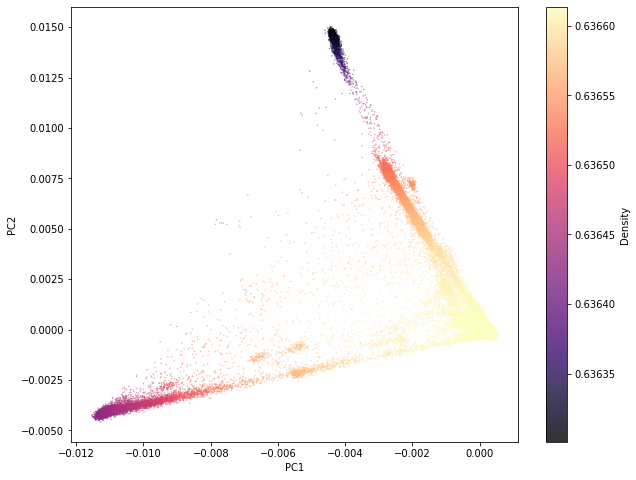

In [100]:
# plot density in 2D PC space
plt.figure(figsize=(10,8))
scatter = plt.scatter(x=data_dens['PC1'],y=data_dens['PC2'],c=data_dens['PC1_PC2_density'],cmap='magma',alpha=0.8,s=0.1)
cbar = plt.colorbar(scatter, label='Density')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

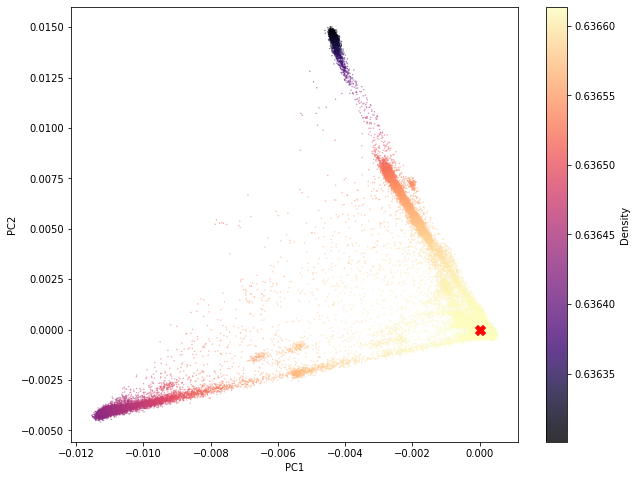

In [103]:
# calculate centroid and plot
mean_pc1 = np.mean(data_dens['PC1'])
mean_pc2 = np.mean(data_dens['PC2'])

plt.figure(figsize=(10,8))
scatter = plt.scatter(x=data_dens['PC1'],y=data_dens['PC2'],c=data_dens['PC1_PC2_density'],cmap='magma',alpha=0.8,s=0.1)
cbar = plt.colorbar(scatter, label='Density')
plt.xlabel('PC1')
plt.ylabel('PC2')

# add centroid
plt.scatter(mean_pc1,mean_pc2,c='red',marker='X',s=100)
plt.show()

In [129]:
evals = pd.read_csv('../pca/results/ukb_pca_plink2.eigenval',delim_whitespace=True,header=None)

In [126]:
# scale by eigenvalues
data_weights_pca = data_dens[['id','PC1','PC2','PC1_PC2_density']]
data_weights_pca['PC1_s'] = data_weights_pca['PC1']/np.sqrt(evals[0][0])
data_weights_pca['PC2_s'] = data_weights_pca['PC2']/np.sqrt(evals[0][1])
centroid_s = np.array([np.mean(data_weights_pca['PC1_s']),np.mean(data_weights_pca['PC2_s'])])
data_weights_pca['distance_centroid'] = np.linalg.norm(data_weights_pca[['PC1_s','PC2_s']].values - centroid_s, axis = 1)

<ipython-input-126-7b6cc2c4129f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_weights_pca['PC1_s'] = data_weights_pca['PC1']/np.sqrt(evals[0][0])
<ipython-input-126-7b6cc2c4129f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_weights_pca['PC2_s'] = data_weights_pca['PC2']/np.sqrt(evals[0][1])
<ipython-input-126-7b6cc2c4129f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

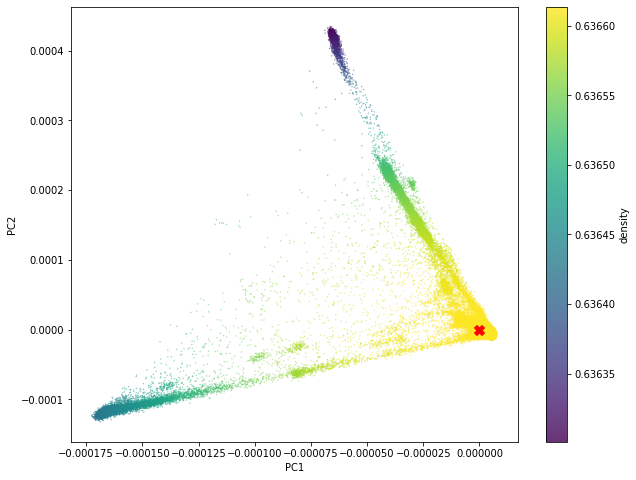

In [138]:
plt.figure(figsize=(10,8))
scatter = plt.scatter(x=data_weights_pca['PC1_s'],y=data_weights_pca['PC2_s'],c=data_weights_pca['PC1_PC2_density'],cmap='viridis',alpha=0.8,s=0.1)
cbar = plt.colorbar(scatter, label='density')
plt.xlabel('PC1')
plt.ylabel('PC2')

# add centroid
plt.scatter(centroid_s[0],centroid_s[1],c='red',marker='X',s=100)
plt.show()

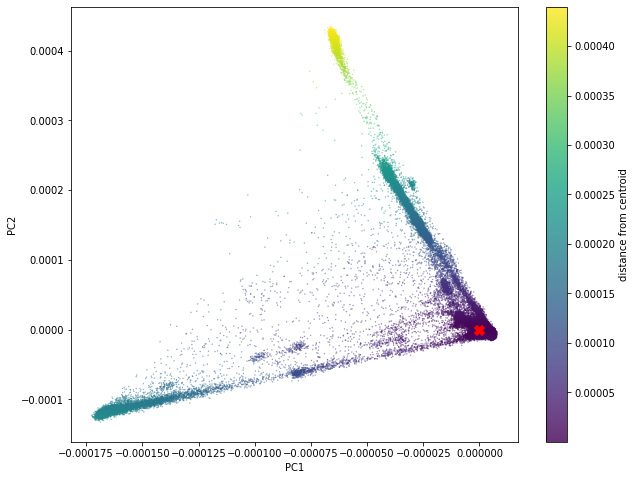

In [128]:
plt.figure(figsize=(10,8))
scatter = plt.scatter(x=data_weights_pca['PC1_s'],y=data_weights_pca['PC2_s'],c=data_weights_pca['distance_centroid'],cmap='viridis',alpha=0.8,s=0.1)
cbar = plt.colorbar(scatter, label='distance from centroid')
plt.xlabel('PC1')
plt.ylabel('PC2')

# add centroid
plt.scatter(centroid_s[0],centroid_s[1],c='red',marker='X',s=100)
plt.show()

In [132]:
sorted_df = data_weights_pca.sort_values(by='distance_centroid')
closest_10k = sorted_df['id'].head(10000).tolist()
df1 = pd.DataFrame({'X1':closest_10k,'X2':closest_10k,'Clust':['closest_10k']*10000})
df1.to_csv('ids_closest_10k.tsv',sep='\t',index=False)

<ipython-input-137-6b49fa75eb9a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_weights_pca['closest_10k'] = data_weights_pca['id'].isin(closest_10k)


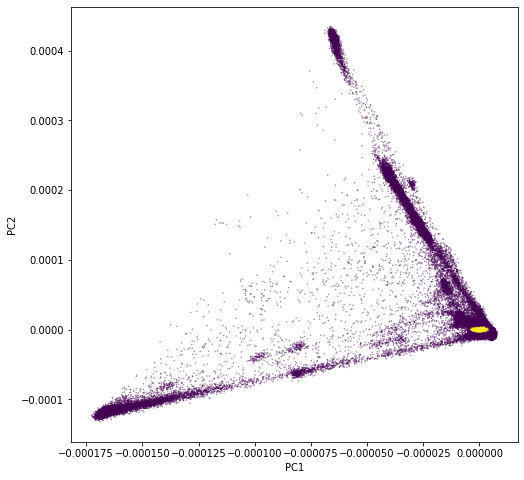

In [137]:
data_weights_pca['closest_10k'] = data_weights_pca['id'].isin(closest_10k)
plt.figure(figsize=(8,8))
scatter = plt.scatter(x=data_weights_pca['PC1_s'],y=data_weights_pca['PC2_s'],c=data_weights_pca['closest_10k'],alpha=0.8,s=0.1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [106]:
def gaussian_2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
    return (1 / (2 * np.pi * sigma_x * sigma_y)) * np.exp(
        -((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2))
    )

In [141]:
sd_pc1 = np.std(data_weights_pca['PC1_s'])
sd_pc2 = np.std(data_weights_pca['PC2_s'])

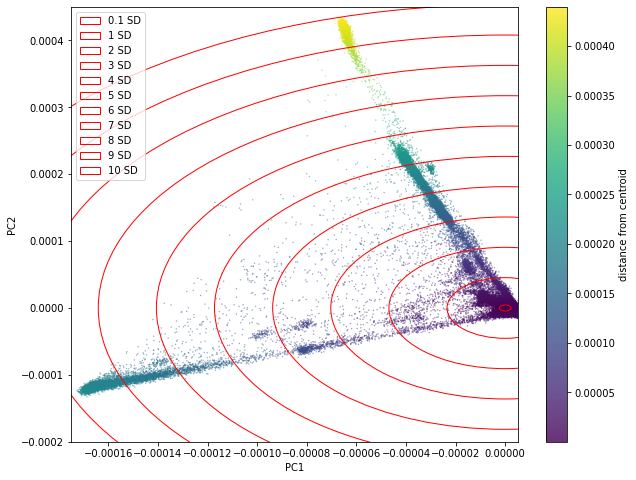

In [181]:
plt.figure(figsize=(10,8))
scatter = plt.scatter(x=data_weights_pca['PC1_s'],y=data_weights_pca['PC2_s'],c=data_weights_pca['distance_centroid'],cmap='viridis',alpha=0.8,s=0.1)
cbar = plt.colorbar(scatter, label='distance from centroid')
plt.xlabel('PC1')
plt.ylabel('PC2')

ellipse_temp = patches.Ellipse(centroid_s,2*0.1*sd_pc1,2*0.1*sd_pc2,edgecolor='red',facecolor='none',label=str(0.1)+" SD")
plt.gca().add_patch(ellipse_temp)
for i in np.arange(10)+1:
    ellipse_temp = patches.Ellipse(centroid_s,2*i*sd_pc1,2*i*sd_pc2,edgecolor='red',facecolor='none',label=str(i)+" SD")
    plt.gca().add_patch(ellipse_temp)
plt.xlim(-0.000175,0.000005)
plt.ylim(-0.0002,0.00045)
plt.legend()
plt.show()

In [183]:
data_weights_pca['01SD_IS'] = data_weights_pca.apply(lambda row: gaussian_2d(row['PC1_s'], row['PC2_s'], centroid_s[0], centroid_s[1], 0.1*sd_pc1, 0.1*sd_pc1), axis=1)/data_weights_pca['PC1_PC2_density']
for i in np.arange(10)+1:
    col_name = str(i)+"SD_IS"
    data_weights_pca[col_name] = data_weights_pca.apply(lambda row: gaussian_2d(row['PC1_s'], row['PC2_s'], centroid_s[0], centroid_s[1], i*sd_pc1, i*sd_pc1), axis=1)/data_weights_pca['PC1_PC2_density']
    

<ipython-input-183-d2cfbb4a460c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_weights_pca['01SD_IS'] = data_weights_pca.apply(lambda row: gaussian_2d(row['PC1_s'], row['PC2_s'], centroid_s[0], centroid_s[1], 0.1*sd_pc1, 0.1*sd_pc1), axis=1)/data_weights_pca['PC1_PC2_density']
<ipython-input-183-d2cfbb4a460c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_weights_pca[col_name] = data_weights_pca.apply(lambda row: gaussian_2d(row['PC1_s'], row['PC2_s'], centroid_s[0], centroid_s[1], i*sd_pc1, 

In [212]:
# data_weights_pca

In [187]:
n=10000
seeds = np.arange(20)
for seed in seeds:
    samp_unif = data_weights_pca.sample(n=n,weights=(1/data_weights_pca['PC1_PC2_density']).replace(float('inf'),0),random_state=seed)
    df_unif = pd.DataFrame({'X1':samp_unif['id'],'X2':samp_unif['id'],'Clust':['UNIF_IS']*n})
    df_unif.to_csv('UNIF_IS_seed'+str(seed)+'_n'+str(n)+'.tsv',sep='\t',index=False)
    samp_temp = data_weights_pca.sample(n=n,weights='01SD_IS',random_state=seed)
    df_temp = pd.DataFrame({'X1':samp_temp['id'],'X2':samp_temp['id'],'Clust':['01SD_IS']*n})
    df_temp.to_csv('01SD_IS_seed'+str(seed)+'_n'+str(n)+'.tsv',sep='\t',index=False)
    for i in np.arange(10)+1:
        samp_temp = data_weights_pca.sample(n=n,weights=str(i)+'SD_IS',random_state=seed)
        df_temp = pd.DataFrame({'X1':samp_temp['id'],'X2':samp_temp['id'],'Clust':[str(i)+'SD_IS']*n})
        df_temp.to_csv(str(i)+'SD_IS_seed'+str(seed)+'_n'+str(n)+'.tsv',sep='\t',index=False)

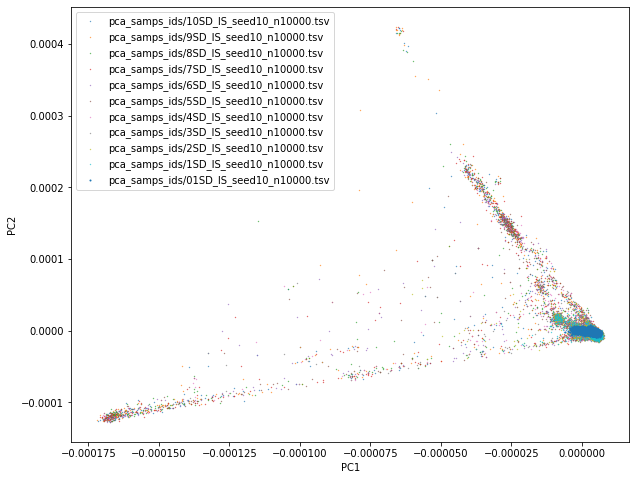

In [209]:
seed_to_plot = 10
plt.figure(figsize=(10, 8))

for i in (np.arange(10)+1)[::-1]:
    files = glob.glob('pca_samps_ids/'+str(i)+'SD_IS_seed'+str(seed_to_plot)+"*")
    dfs = {file: pd.read_csv(file,sep="\t") for file in files}

    for df in dfs.values():
        if df.columns[0] != 'ID':
            df.rename(columns={df.columns[0]: 'id'}, inplace=True)
    merged_dataframes = {file: pd.merge(data_weights_pca, df, on='id') for file, df in dfs.items()}
    
    for file, merged_df in merged_dataframes.items():
        plt.scatter(merged_df['PC1_s'], merged_df['PC2_s'], label=file,s=0.1)



files = glob.glob('pca_samps_ids/01SD_IS_seed'+str(seed_to_plot)+"*")
dfs = {file: pd.read_csv(file,sep="\t") for file in files}

for df in dfs.values():
    if df.columns[0] != 'ID':
        df.rename(columns={df.columns[0]: 'id'}, inplace=True)
merged_dataframes = {file: pd.merge(data_weights_pca, df, on='id') for file, df in dfs.items()}
for file, merged_df in merged_dataframes.items():
    plt.scatter(merged_df['PC1_s'], merged_df['PC2_s'], label=file,s=1)



# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

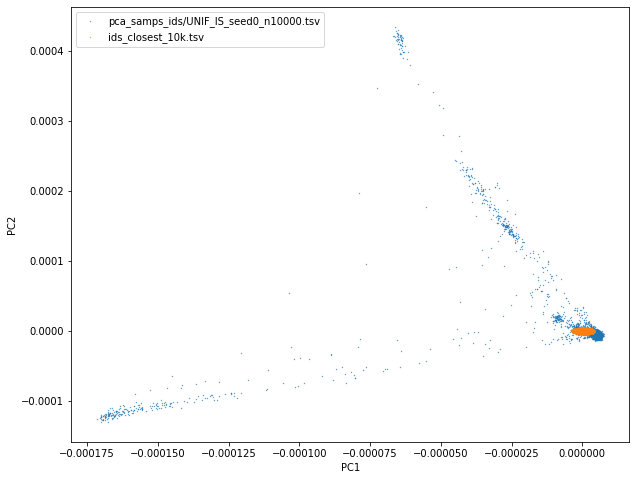

In [211]:
seed_to_plot = 0
plt.figure(figsize=(10, 8))

files = glob.glob('pca_samps_ids/UNIF*seed'+str(seed_to_plot)+'*')
dfs = {file: pd.read_csv(file,sep="\t") for file in files}

for df in dfs.values():
    if df.columns[0] != 'ID':
        df.rename(columns={df.columns[0]: 'id'}, inplace=True)
merged_dataframes = {file: pd.merge(data_weights_pca, df, on='id') for file, df in dfs.items()}
for file, merged_df in merged_dataframes.items():
    plt.scatter(merged_df['PC1_s'], merged_df['PC2_s'], label=file,s=0.1)   

files = ['ids_closest_10k.tsv']
dfs = {file: pd.read_csv(file,sep="\t") for file in files}
for df in dfs.values():
    if df.columns[0] != 'ID':
        df.rename(columns={df.columns[0]: 'id'}, inplace=True)
merged_dataframes = {file: pd.merge(data_weights_pca, df, on='id') for file, df in dfs.items()}
for file, merged_df in merged_dataframes.items():
        plt.scatter(merged_df['PC1_s'], merged_df['PC2_s'], label=file,s=0.1)   


# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

## Geographic space

In [ ]:
### add in geographic space density
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(data_dens[['birth_east_coord', 'birth_north_coord']].values)
log_density = kde.score_samples(data_dens[['birth_east_coord','birth_north_coord']].values)
data_dens['birth_coord_density'] = np.exp(log_density)
data_dens.to_csv('meta_pcs_density_geo.csv')

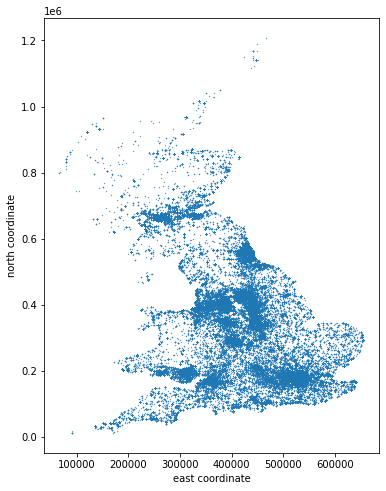

In [105]:
plt.figure(figsize=(6,8))
scatter = plt.scatter(x=data_dens['birth_east_coord'],y=data_dens['birth_north_coord'],s=0.1)
plt.xlabel('east coordinate')
plt.ylabel('north coordinate')
plt.show()